# Splice scorers


This notebook shows distribution of scores of variants as calculated by *EselatorSimulations* code.

- [All positive cases together](#All-positive-cases-together)
  - [Load the positive cases](#Load-the-positive-cases)
  - [Load ClinVar variants](#Load-ClinVar-variants)
  - [Merge scores into a single dataframe](#Merge-scores-into-a-single-dataframe)
  - [Plot all variants](#Plot-all-variants)
- [Positive cases considering relevance](#Positive-cases-considering-relevance) - variants that have specific pathomechanism are plotted in the *Extra* category. The rest of *Curated* variants and *ClinVar* variants are plotted next to *Extra* category:
  - for [canonical donor](#Canonical-donor) the *Extra* pathomechanism is `splicing|5ss|disrupted`
  - for [cryptic donor](#Cryptic-donor) the *Extra* pathomechanism is `splicing|5css|activated`
  - for [canonical acceptor](#Canonical-acceptor) the *Extra* pathomechanism is `splicing|3ss|disrupted`
  - for [cryptic acceptor](#Cryptic-acceptor) the *Extra* pathomechanism is `splicing|3css|activated`

- [Derive scaling functions](#Derive-scaling-functions) for all the scorers
  - [Scale cryptic donor scorer](#Scale-cryptic-donor-scorer)

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid", palette="Set2", color_codes=True)
figsize=(16, 8)
dpi = 300

## All positive cases together
### Load the positive cases
#### Info
The file `scorers-all.tsv` that is being read contains biocurated variants that are located in `hrmd/data/splicing/all/hca-1.0.7/json`. Variants have been exported into `data/eselator-simulations/phenopackets` using *Hpo Case Annotator*'s export function.

#### How to create
This dataset has been created by running:

```bash
java -jar simulations-cli-0.2.0.jar --splice-scorer --exomiser.data-directory=/home/ielis/data/exomiser-data --output=/home/ielis/data/eselator-simulations/scorers-all.tsv
--pp=/home/ielis/data/eselator-simulations/phenopackets-all/Aceto-2005-APC.json
--pp=/home/ielis/data/eselator-simulations/phenopackets-all/Aguilar-Ramirez-2009-C5.json
--pp=/home/ielis/data/eselator-simulations/phenopackets-all/Aldahmesh-2009-CTNS.json

# ... omitted for brevity

--pp=/home/ielis/data/eselator-simulations/phenopackets-all/Zatkova-2004-NF1.json
```

In [2]:
POS_PATH = "/home/ielis/data/eselator-simulations/scorers-all.tsv"
positive_cases = pd.read_table(POS_PATH)
positive_cases.head(n=1)

,PP_ID,VARIANT,VCLASS,PATHOMECHANISM,CONSEQUENCE,CANONICAL_ACCEPTOR,CANONICAL_DONOR,CRYPTIC_ACCEPTOR,CRYPTIC_ACCEPTOR_FOR_ACCEPTOR_VARIANTS,CRYPTIC_DONOR,CRYPTIC_DONOR_FOR_DONOR_VARIANTS,HEXAMER
0,Aceto-2005-APC,5:112128142G>A,splicing,splicing|3ss|disrupted,Alternative/cryptic 3' splice site,9.960002,NaN,NaN,-0.547678,NaN,NaN,NaN


### Load ClinVar variants

#### Info

The file `clinvar.tsv` contains ClinVar variants with `CLNSIG=Benign`. The variants have been annotated with splicing scorers.

#### How to create
This dataset has been created by running

```bash
java -jar simulations-cli-0.2.0.jar --clinvar-scorer --exomiser.data-directory=/home/ielis/data/exomiser-data --clinvar-vcf=/home/ielis/tempelhof/clinVar/20190408/clinvar.filtered.vcf.gz --output=/home/ielis/data/eselator-simulations/clinvar.tsv
```

In [3]:
CLINVAR_PATH = "/home/ielis/data/eselator-simulations/clinvar_benign.tsv"

clinvar_benign_cases = pd.read_table(CLINVAR_PATH)
clinvar_benign_cases.head(n=1)

,VARIANT,CANONICAL_ACCEPTOR,CANONICAL_DONOR,CRYPTIC_ACCEPTOR,CRYPTIC_ACCEPTOR_FOR_ACCEPTOR_VARIANTS,CRYPTIC_DONOR,CRYPTIC_DONOR_FOR_DONOR_VARIANTS,HEXAMER
0,1:949422G>A,NaN,NaN,-3.78016,NaN,-4.289216,NaN,0.801761


### Merge scores into a single dataframe

Both `clinvar_benign_cases` and `positive_cases` share score columns: `['CANONICAL_ACCEPTOR', 'CANONICAL_DONOR', 'CRYPTIC_ACCEPTOR', 'CRYPTIC_ACCEPTOR_FOR_ACCEPTOR_VARIANTS', 'CRYPTIC_DONOR', 'CRYPTIC_DONOR_FOR_DONOR_VARIANTS', 'HEXAMER']`.

Here, additional `SOURCE` column will be added, where values `ClinVar`, and `Curated` will be present.

In [4]:
SCORER_NAMES = ['Canonical\ndonor',  'Cryptic\ndonor', 'Cryptic donor\nfor variants\nin donor site',
                  'Canonical\nacceptor','Cryptic\nacceptor', 'Cryptic acceptor\nfor variants\nin acceptor site',
                  'Hexamer']
SCORER_COLUMNS = ['CANONICAL_DONOR',  'CRYPTIC_DONOR', 'CRYPTIC_DONOR_FOR_DONOR_VARIANTS',
                  'CANONICAL_ACCEPTOR','CRYPTIC_ACCEPTOR', 'CRYPTIC_ACCEPTOR_FOR_ACCEPTOR_VARIANTS',
                  'HEXAMER']
COLUMNS = ['VARIANT'] + SCORER_COLUMNS

# Join positive and ClinVar benign variant data
joined = pd.concat([clinvar_benign_cases.loc[:, COLUMNS].assign(SOURCE='ClinVar'), 
 positive_cases.loc[:, COLUMNS].assign(SOURCE='Curated')])

# Melt to make plotting easier
id_vars = ["VARIANT", "SOURCE"]
joined_melted = joined.melt(id_vars=id_vars, value_vars=SCORER_COLUMNS, var_name="SCORER", value_name="SCORE")
joined_melted.head(n=1)

,VARIANT,SOURCE,SCORER,SCORE
0,1:949422G>A,ClinVar,CANONICAL_DONOR,NaN


### Plot all variants

/home/ielis/anaconda3/envs/eselearner/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


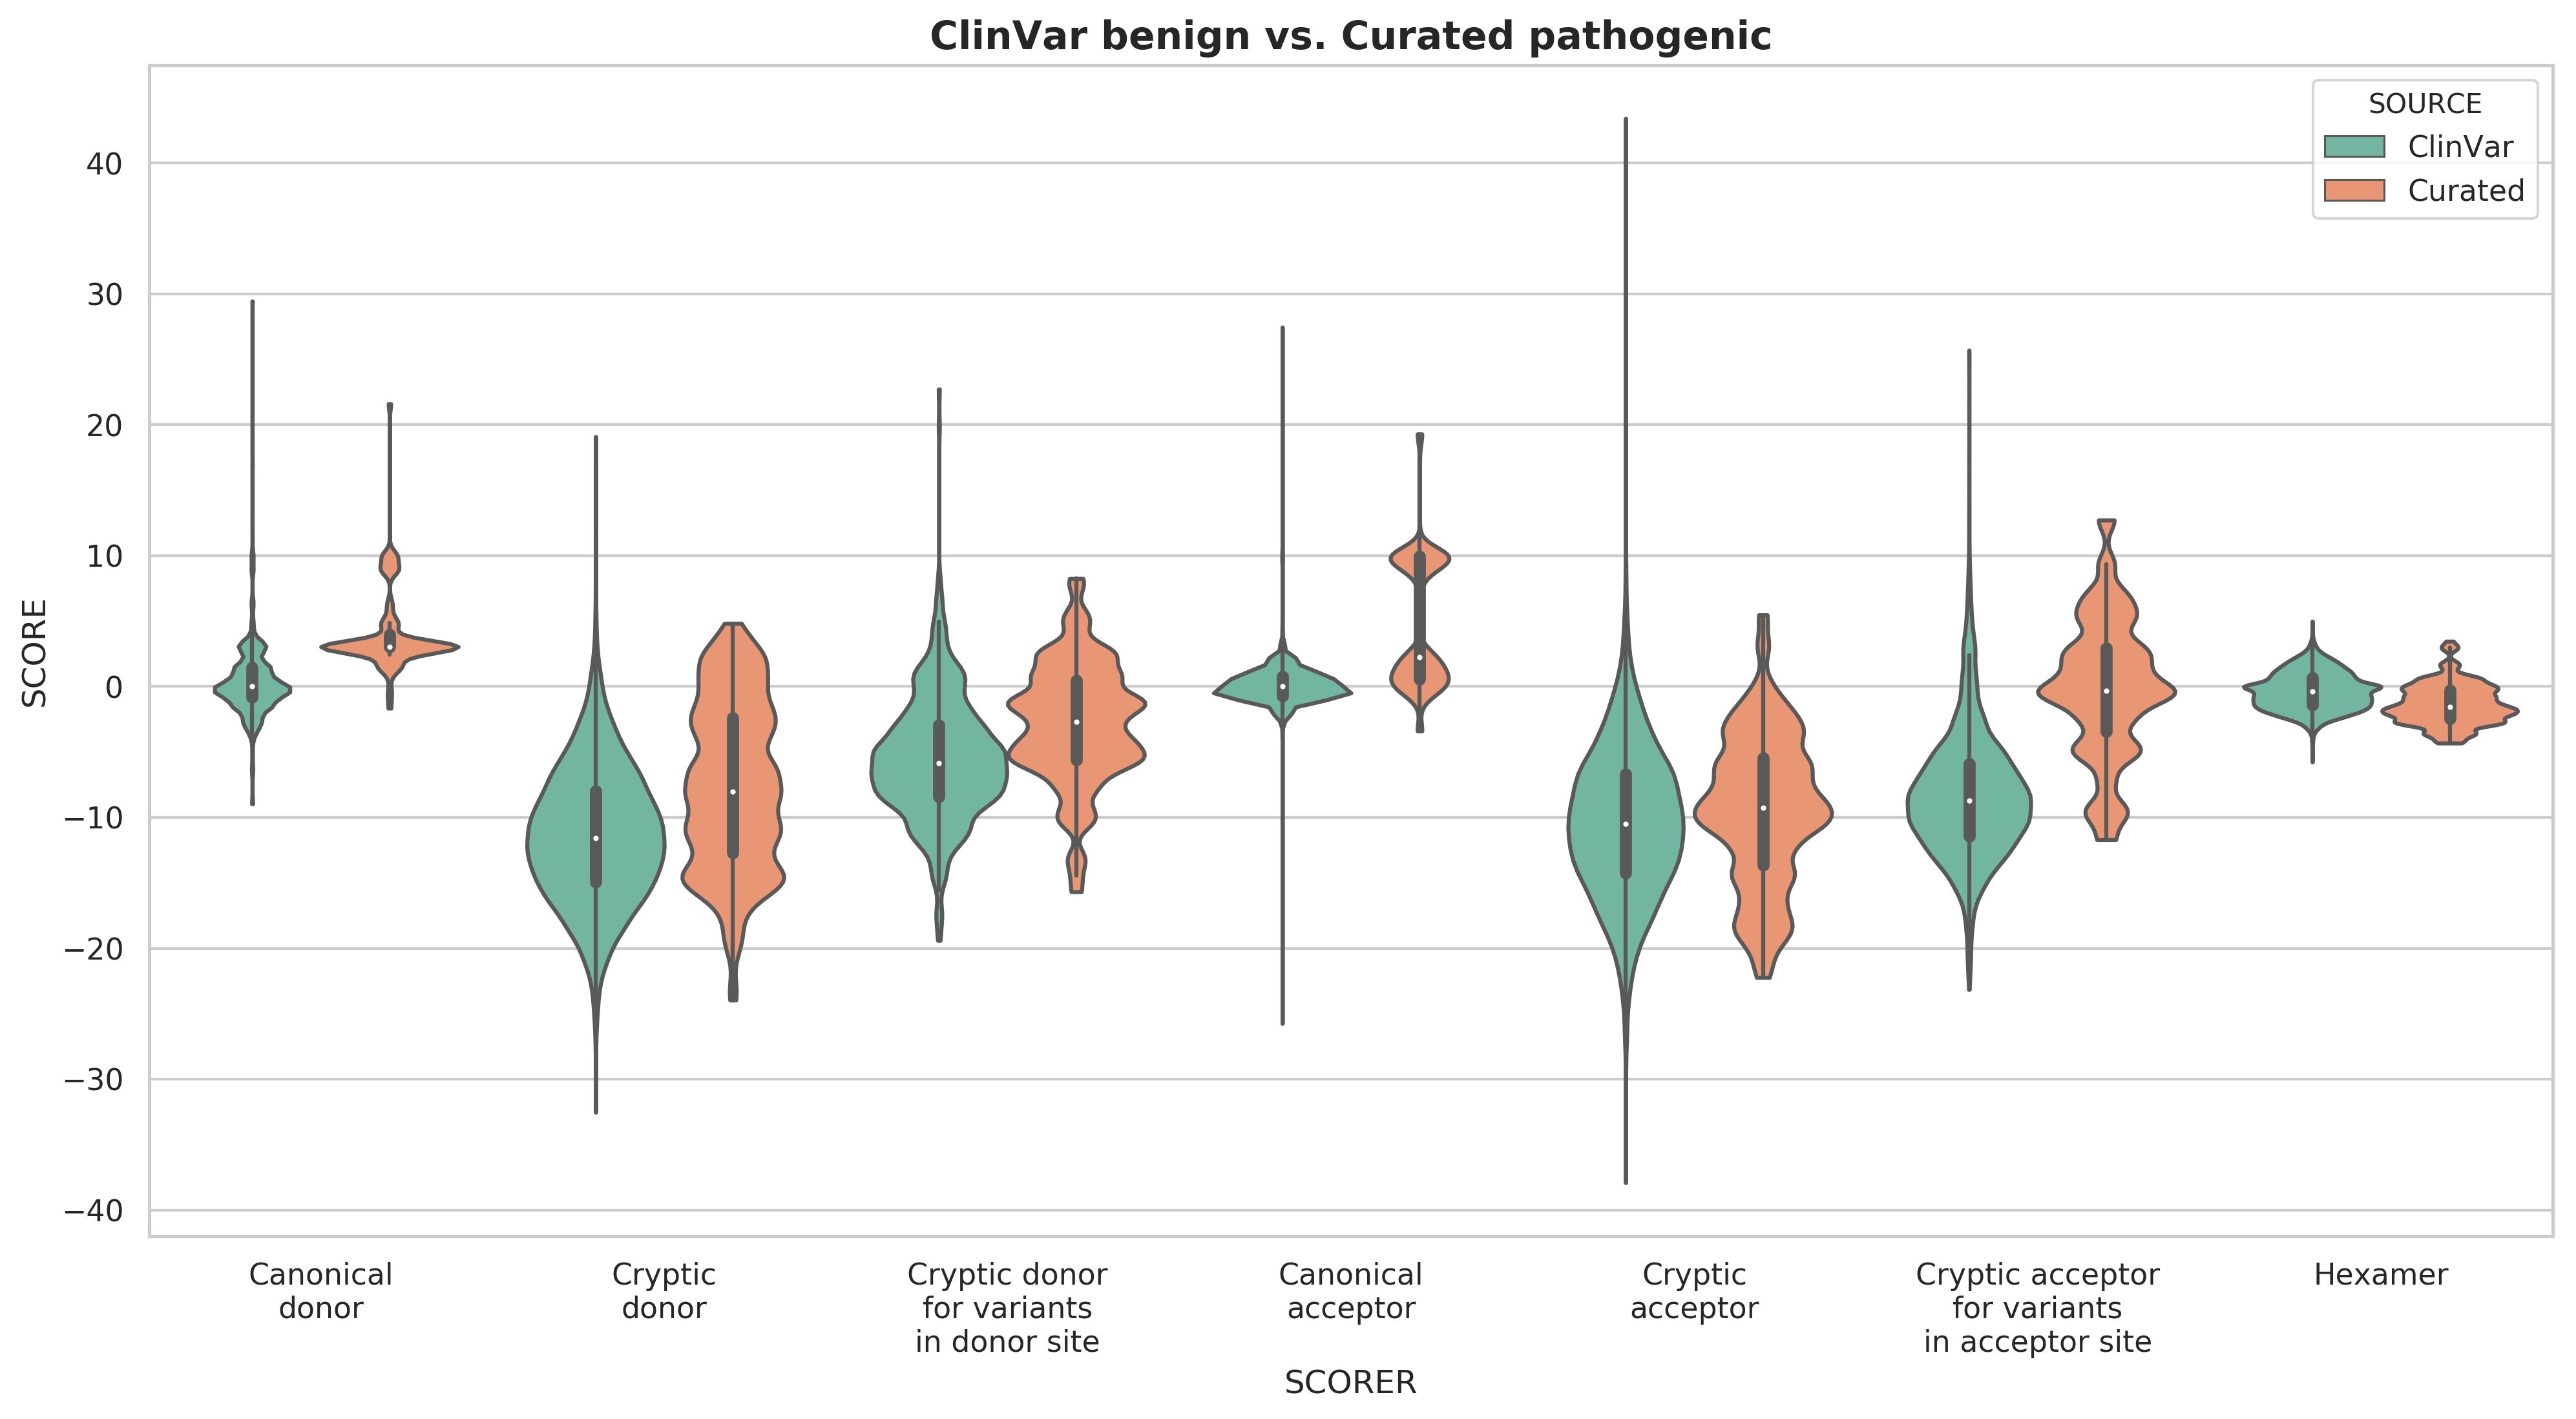

In [5]:
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
split_violin = sns.violinplot(x="SCORER", y="SCORE", hue="SOURCE", palette="Set2", bw=.15, cut=0,
                              data=joined_melted, ax=ax) 
xticklabels = split_violin.set_xticklabels(SCORER_NAMES)
ax_title = ax.set_title("ClinVar benign vs. Curated pathogenic", size='x-large', weight='bold')

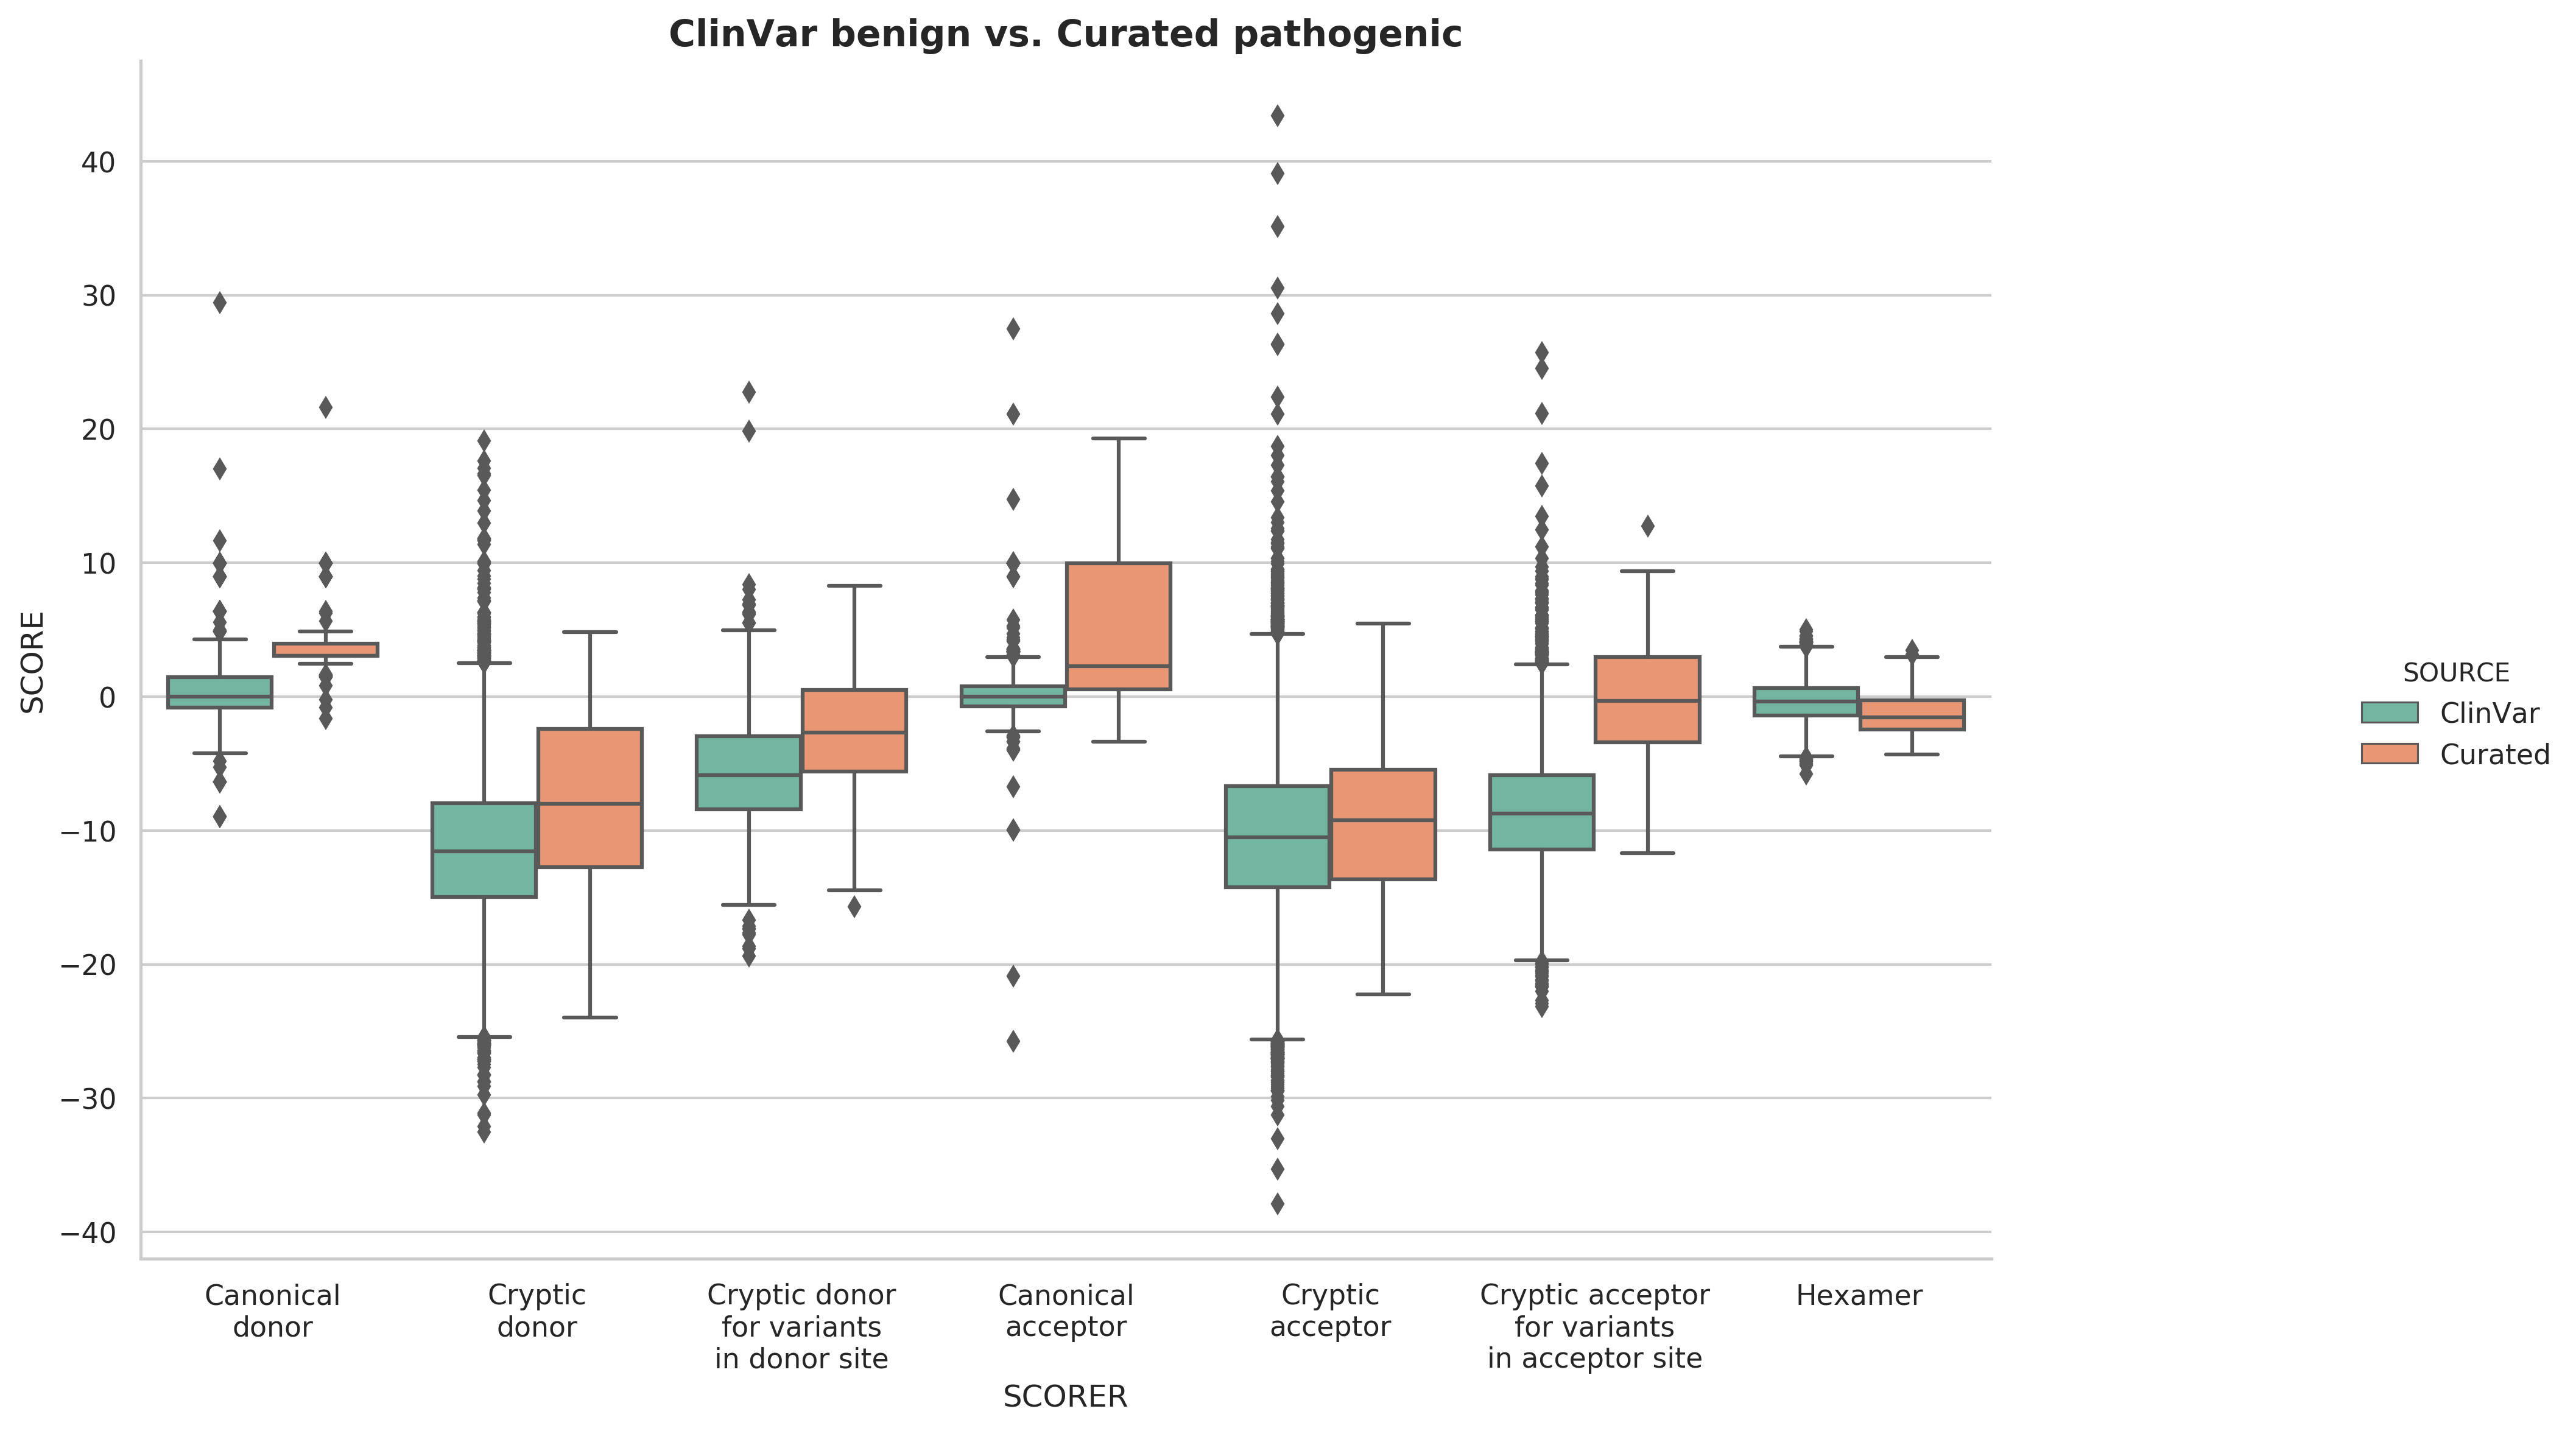

In [6]:
cat = sns.catplot(x="SCORER", y="SCORE", hue="SOURCE", data=joined_melted, kind='box', palette="Set2")
xticklabels = cat.ax.set_xticklabels(SCORER_NAMES)
cat.ax.get_figure().set_size_inches(*figsize)
cat.ax.get_figure().set_dpi(dpi)
ax_title = cat.ax.set_title("ClinVar benign vs. Curated pathogenic", size='x-large', weight='bold')

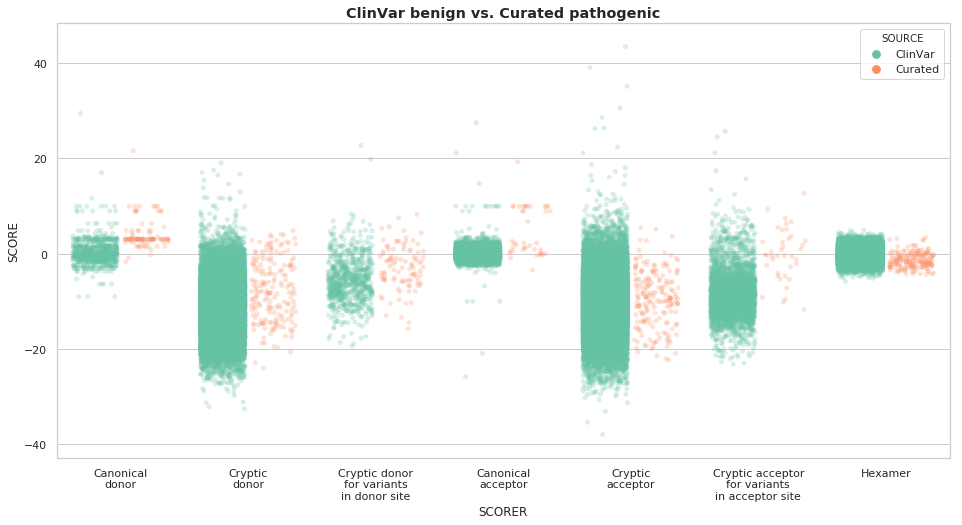

In [7]:
strip = sns.stripplot(x="SCORER", y="SCORE", hue="SOURCE", data=joined_melted, dodge=True, jitter=.35, alpha=.25,
                      palette="Set2")
strip.get_figure().set_size_inches(*figsize)
cat.ax.get_figure().set_dpi(dpi)
xticklabels = strip.set_xticklabels(SCORER_NAMES)
ax_title = strip.set_title("ClinVar benign vs. Curated pathogenic", size='x-large', weight='bold')

## Positive cases considering relevance

Here we consider which variants should particular scorers actually score best. 

I.e., *Canonical donor* scorer should give high scores to variants, that have pathomechanism == `splicing|5ss|disrupted`.

In [8]:
# Prepare the data for plotting
SCORER_COLUMNS = ['CANONICAL_DONOR',  'CRYPTIC_DONOR', 'CRYPTIC_DONOR_FOR_DONOR_VARIANTS', 'CANONICAL_ACCEPTOR',
                  'CRYPTIC_ACCEPTOR', 'CRYPTIC_ACCEPTOR_FOR_ACCEPTOR_VARIANTS', 'HEXAMER']
CSQ_COLUMNS = ['VARIANT', 'CONSEQUENCE', 'PATHOMECHANISM'] + SCORER_COLUMNS

# Add SOURCE column with 'ClinVar' or 'Curated'
csq_joined = pd.concat([clinvar_benign_cases.loc[:, COLUMNS].assign(SOURCE='ClinVar'), 
 positive_cases.loc[:, CSQ_COLUMNS].assign(SOURCE='Curated')], sort=False)

# Melt to make plotting easier
id_vars = ["VARIANT", "SOURCE", "CONSEQUENCE", "PATHOMECHANISM"]
csq_joined_melted = csq_joined.melt(id_vars=id_vars, value_vars=SCORER_COLUMNS, var_name="SCORER", value_name="SCORE")

# Map CONSEQUENCE to friedlier values
def group_consequence(element):
    if isinstance(element, pd.Series):
        csq = element['CONSEQUENCE']
    else:
        csq = element
        
    if isinstance(csq, float):
        return "None"    
    elif csq == "Alternative/cryptic 5' splice site":
        return "5_CSS"
    elif csq == "Alternative/cryptic 3' splice site":
        return "3_CSS"
    elif csq in ("Exon skipping", "Multiple exons skipped"):
        return "EXON_SKIP"
    return csq

csq_joined_melted["CSQ"] = csq_joined_melted.CONSEQUENCE.map(group_consequence)
csq_joined_melted.head(n=1)

,VARIANT,SOURCE,CONSEQUENCE,PATHOMECHANISM,SCORER,SCORE,CSQ
0,1:949422G>A,ClinVar,NaN,NaN,CANONICAL_DONOR,NaN,None


### Canonical donor

Here, relevant variants are thos which have `splicing|5ss|disrupted`. We want these variants to have high score.

Possible consequences of these variants are:
- Exon skipping
- Alt 5'CSS
- Increased inclusion of alt spliced exon
- N/A
- Intron retention

---------

**Actions taken below:**
- make function that assigns variants with 'pathomechanism == `splicing|5ss|disrupted`' class *Extra*
- plot the data

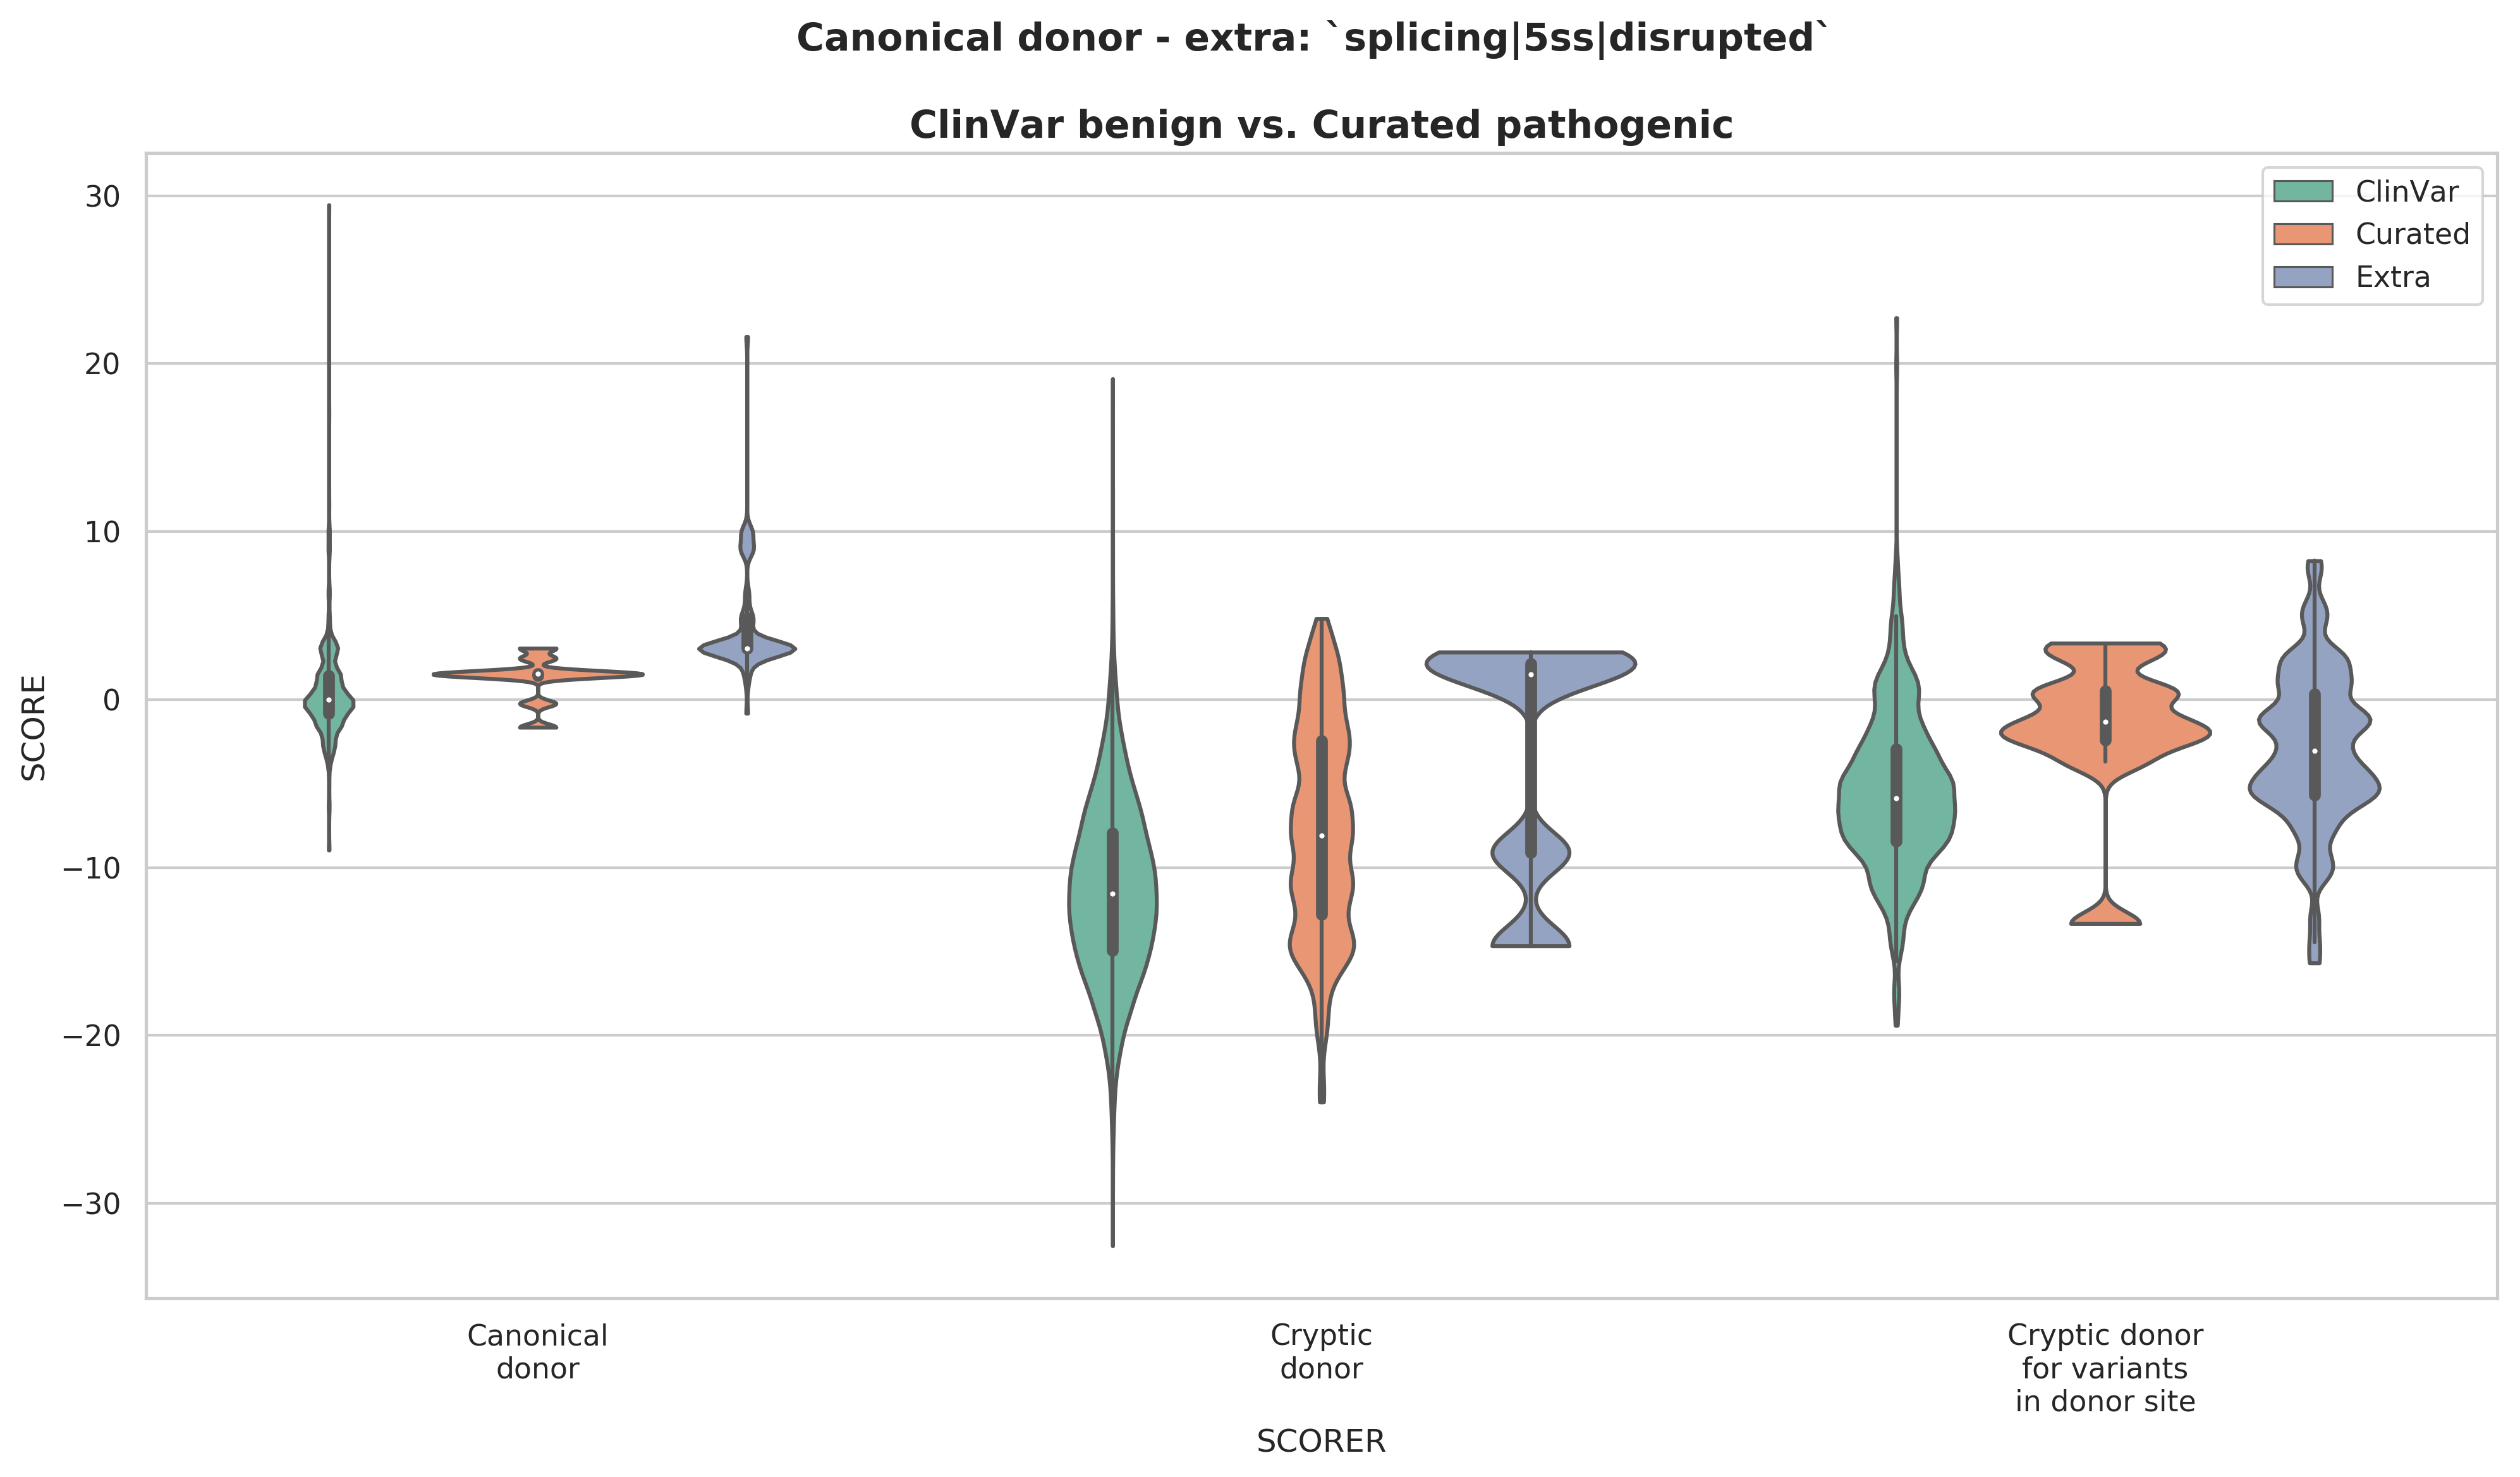

In [9]:
def canonical_donor_huer(row):
    p = row.PATHOMECHANISM
    if p == "splicing|5ss|disrupted":
        return "Extra"
    return row.SOURCE

fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

# prepare data
scorers = ['CANONICAL_DONOR', 'CRYPTIC_DONOR', 'CRYPTIC_DONOR_FOR_DONOR_VARIANTS']
scorer_names = ['Canonical\ndonor',  'Cryptic\ndonor', 'Cryptic donor\nfor variants\nin donor site']
plot_title = "Canonical donor - extra: `splicing|5ss|disrupted` \n\nClinVar benign vs. Curated pathogenic"

to_plot = csq_joined_melted.loc[csq_joined_melted.SCORER.map(lambda x: x in scorers), :]
mask = csq_joined_melted.apply(canonical_donor_huer, axis=1)
hue_order = sorted(csq_joined_melted.apply(canonical_donor_huer, axis=1).unique())

split_violin = sns.violinplot(x="SCORER", y="SCORE", hue=mask, data=to_plot, bw=.15, cut=0, ax=ax)
xticklabels = split_violin.set_xticklabels(scorer_names)
ax_title = ax.set_title(plot_title, size='x-large', weight='bold')

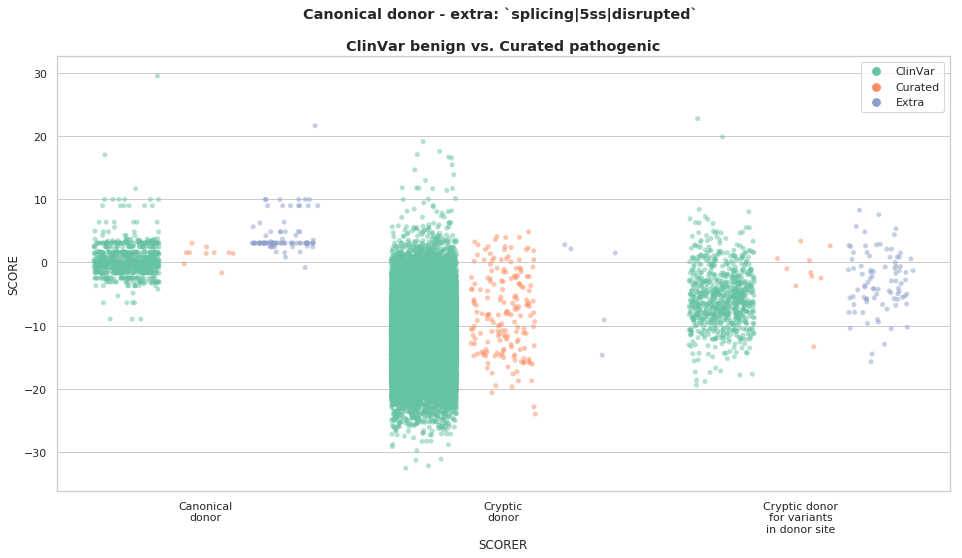

In [10]:
strip = sns.stripplot(x="SCORER", y="SCORE", hue=mask, data=to_plot, dodge=True, jitter=.33, alpha=.50, palette="Set2")
strip.get_figure().set_size_inches(*figsize)
cat.ax.get_figure().set_dpi(dpi)
xticklabels = strip.set_xticklabels(scorer_names)
ax_title = strip.set_title(plot_title, size='x-large', weight='bold')

### Cryptic donor

Here, relevant variants are thos which have `splicing|5css|activated`. We want these variants to have high score when using scorers *Cryptic donor* and *Cryptic donor for variants in donor site*.

Possible consequences of these variants are:
- Alt 5'CSS
- Pseudoexon inclusion
- Exon skipping
- Intron retention

---------

**Actions taken below:**
- make function that assigns variants with 'pathomechanism == `splicing|5css|activated`' class *Extra*
- plot the data

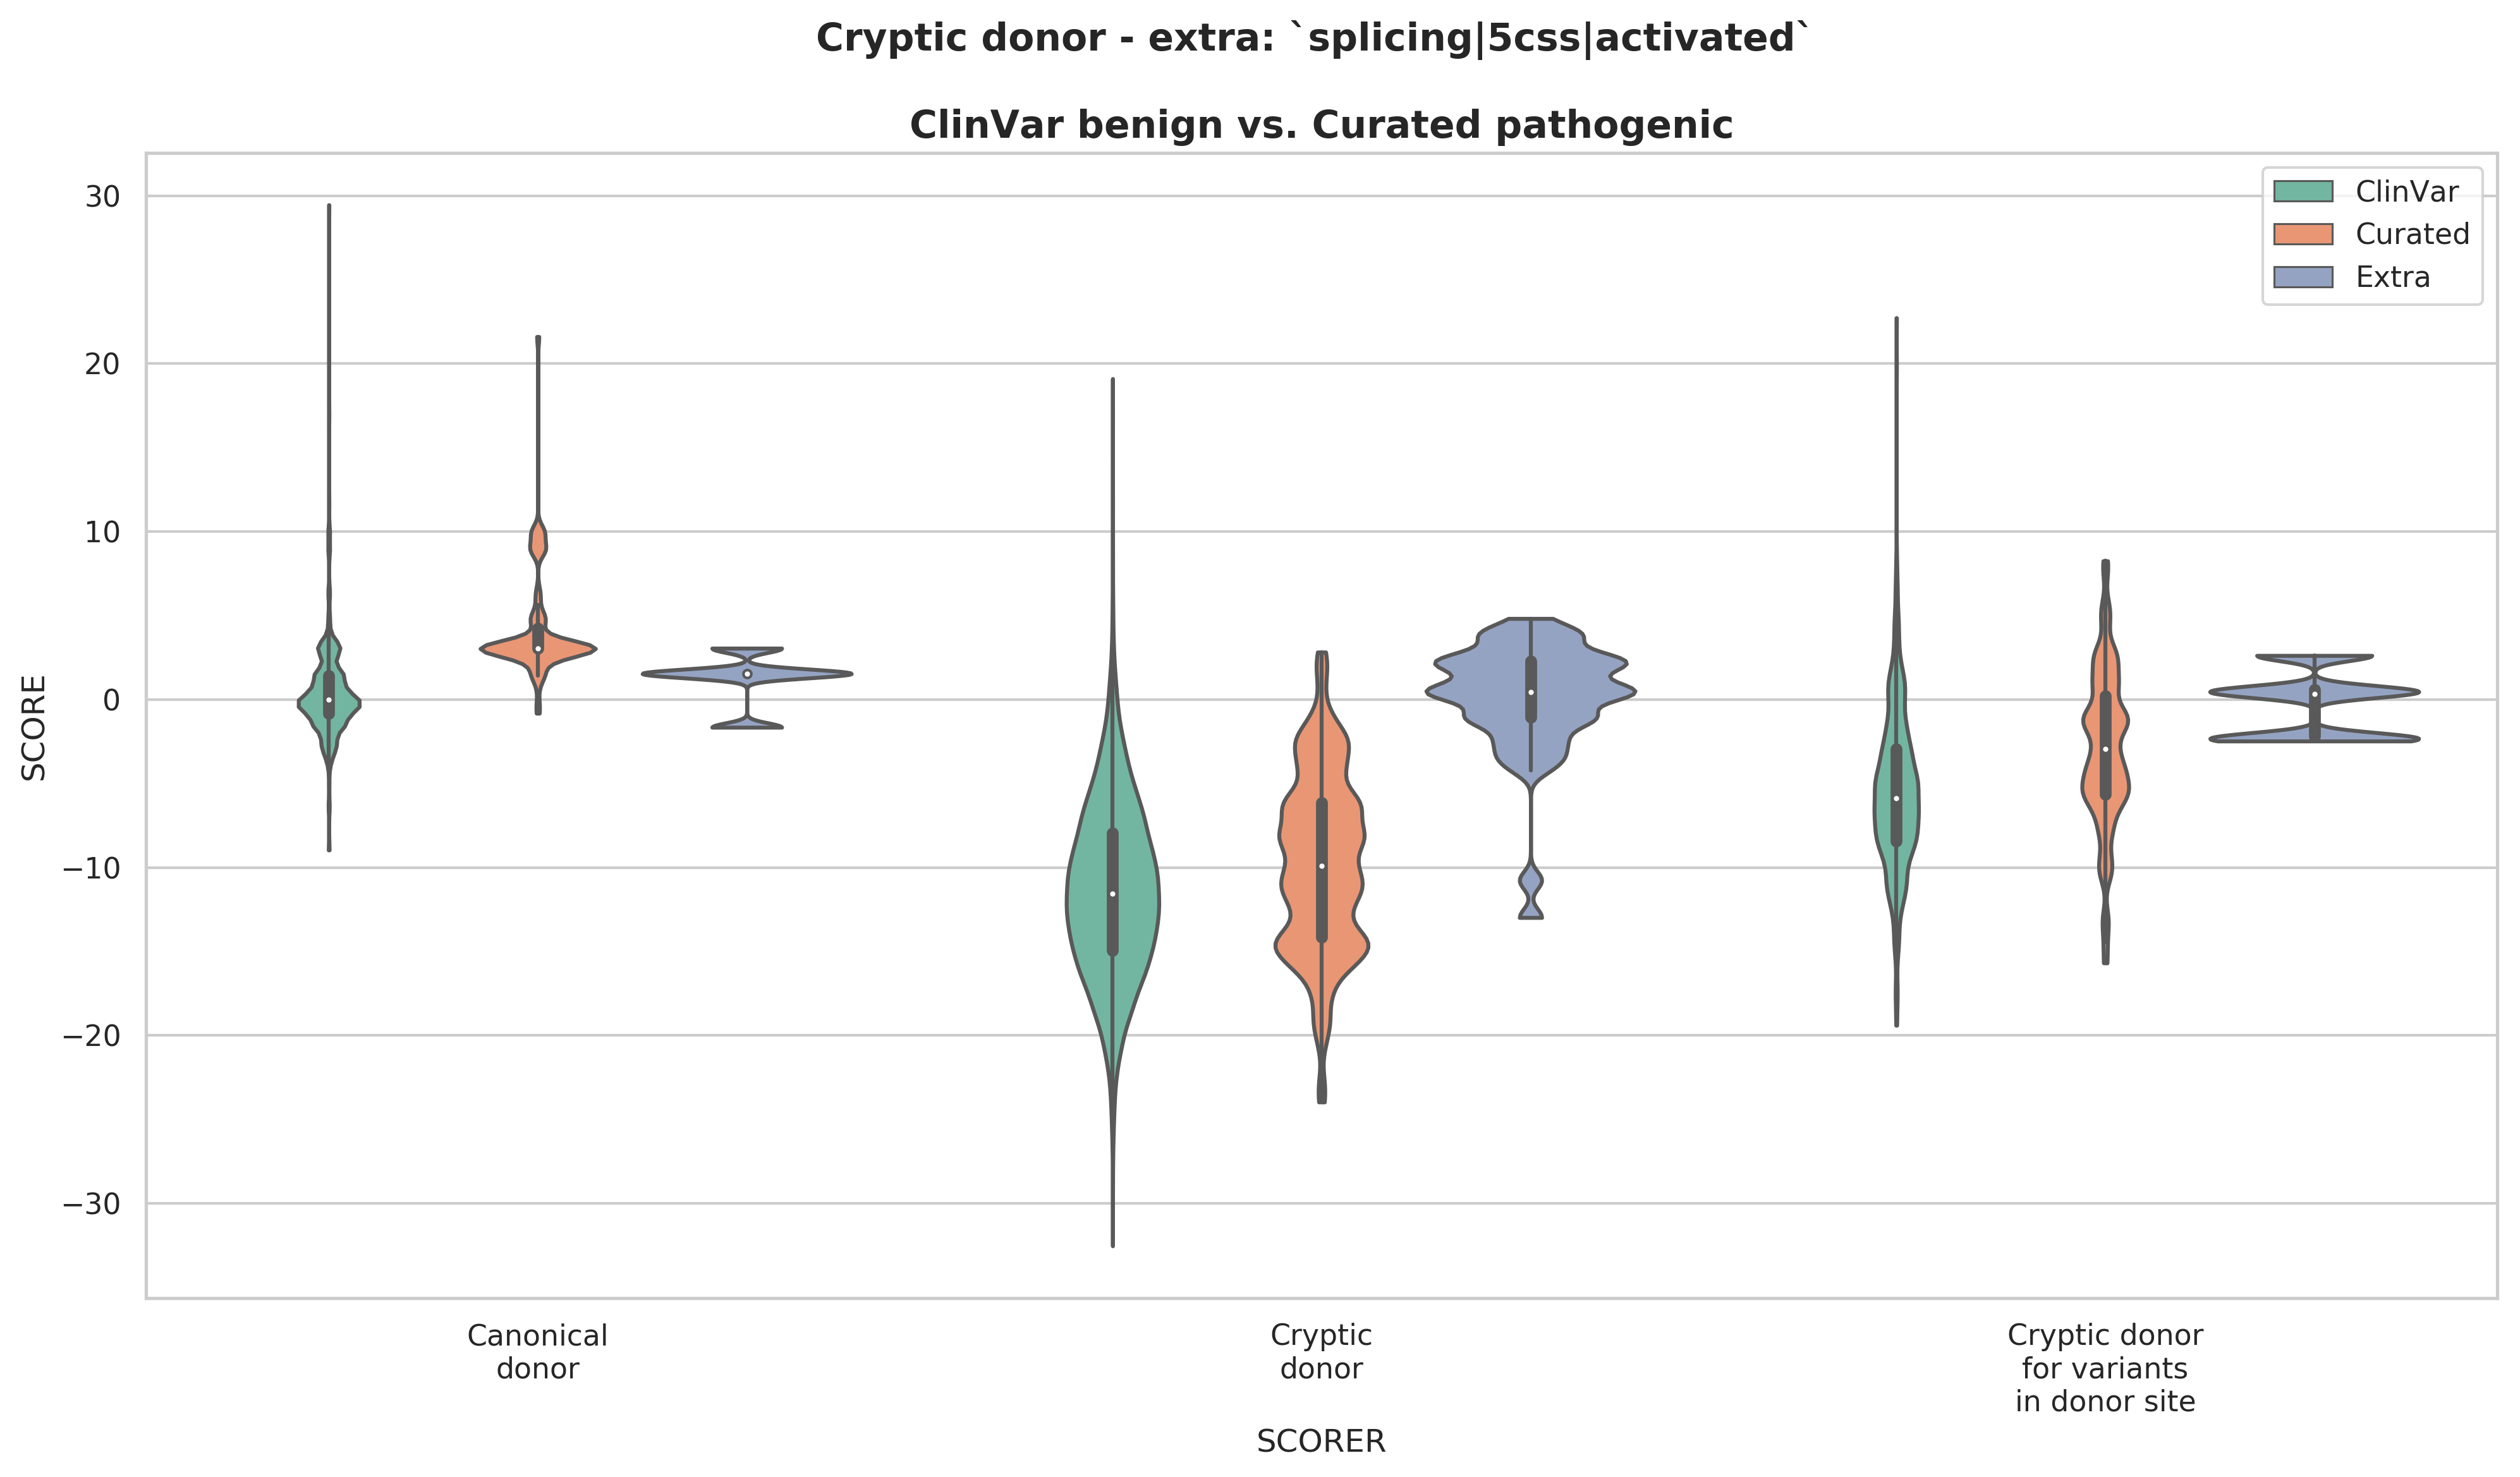

In [11]:
def cryptic_donor_huer(row):
    p = row.PATHOMECHANISM
    if p == "splicing|5css|activated":
        return "Extra"
    return row.SOURCE

fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

# prepare data
scorers = ['CANONICAL_DONOR', 'CRYPTIC_DONOR', 'CRYPTIC_DONOR_FOR_DONOR_VARIANTS']
scorer_names = ['Canonical\ndonor',  'Cryptic\ndonor', 'Cryptic donor\nfor variants\nin donor site']
plot_title = "Cryptic donor - extra: `splicing|5css|activated` \n\nClinVar benign vs. Curated pathogenic"

to_plot = csq_joined_melted.loc[csq_joined_melted.apply(lambda x: x.SCORER in scorers, axis=1), :]
mask = csq_joined_melted.apply(cryptic_donor_huer, axis=1)

split_violin = sns.violinplot(x="SCORER", y="SCORE", hue=mask, hue_order=hue_order, data=to_plot, bw=.15, cut=0, ax=ax)
xticklabels = split_violin.set_xticklabels(scorer_names)
ax_title = ax.set_title(plot_title, size='x-large', weight='bold')

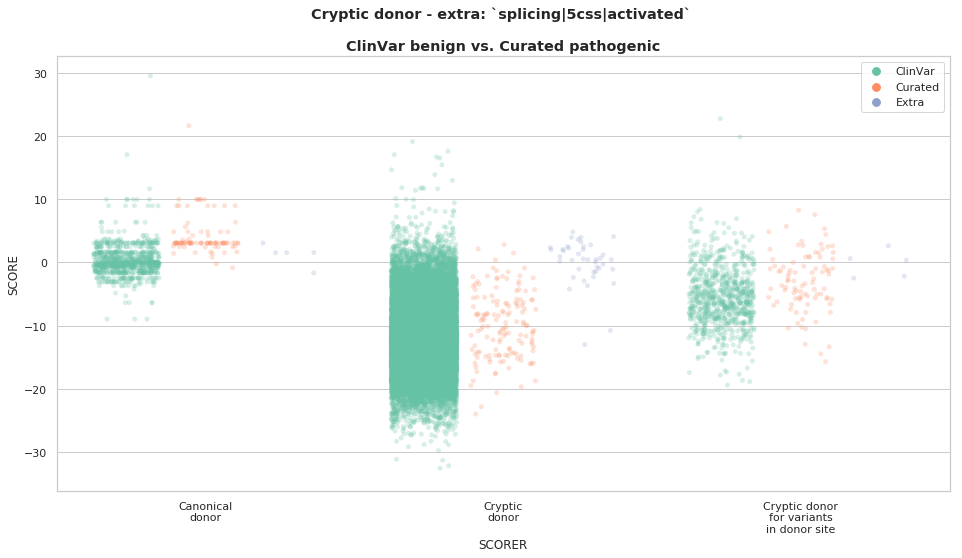

In [12]:
strip = sns.stripplot(x="SCORER", y="SCORE", hue=mask, data=to_plot, dodge=True, hue_order=hue_order, jitter=.33, alpha=.25, palette="Set2")
strip.get_figure().set_size_inches(*figsize)
cat.ax.get_figure().set_dpi(dpi)
xticklabels = strip.set_xticklabels(scorer_names)
ax_title = strip.set_title(plot_title, size='x-large', weight='bold')

### Canonical acceptor

Here, relevant variants are thos which have `splicing|3ss|disrupted`. We want these variants to have high score.

Possible consequences of these variants are:
- Exon skipping
- Alt 5'CSS
- Increased inclusion of alt spliced exon
- N/A
- Intron retention

---------

**Actions taken below:**
- make function that assigns variants with 'pathomechanism == `splicing|3ss|disrupted`' class *Extra*
- plot the data

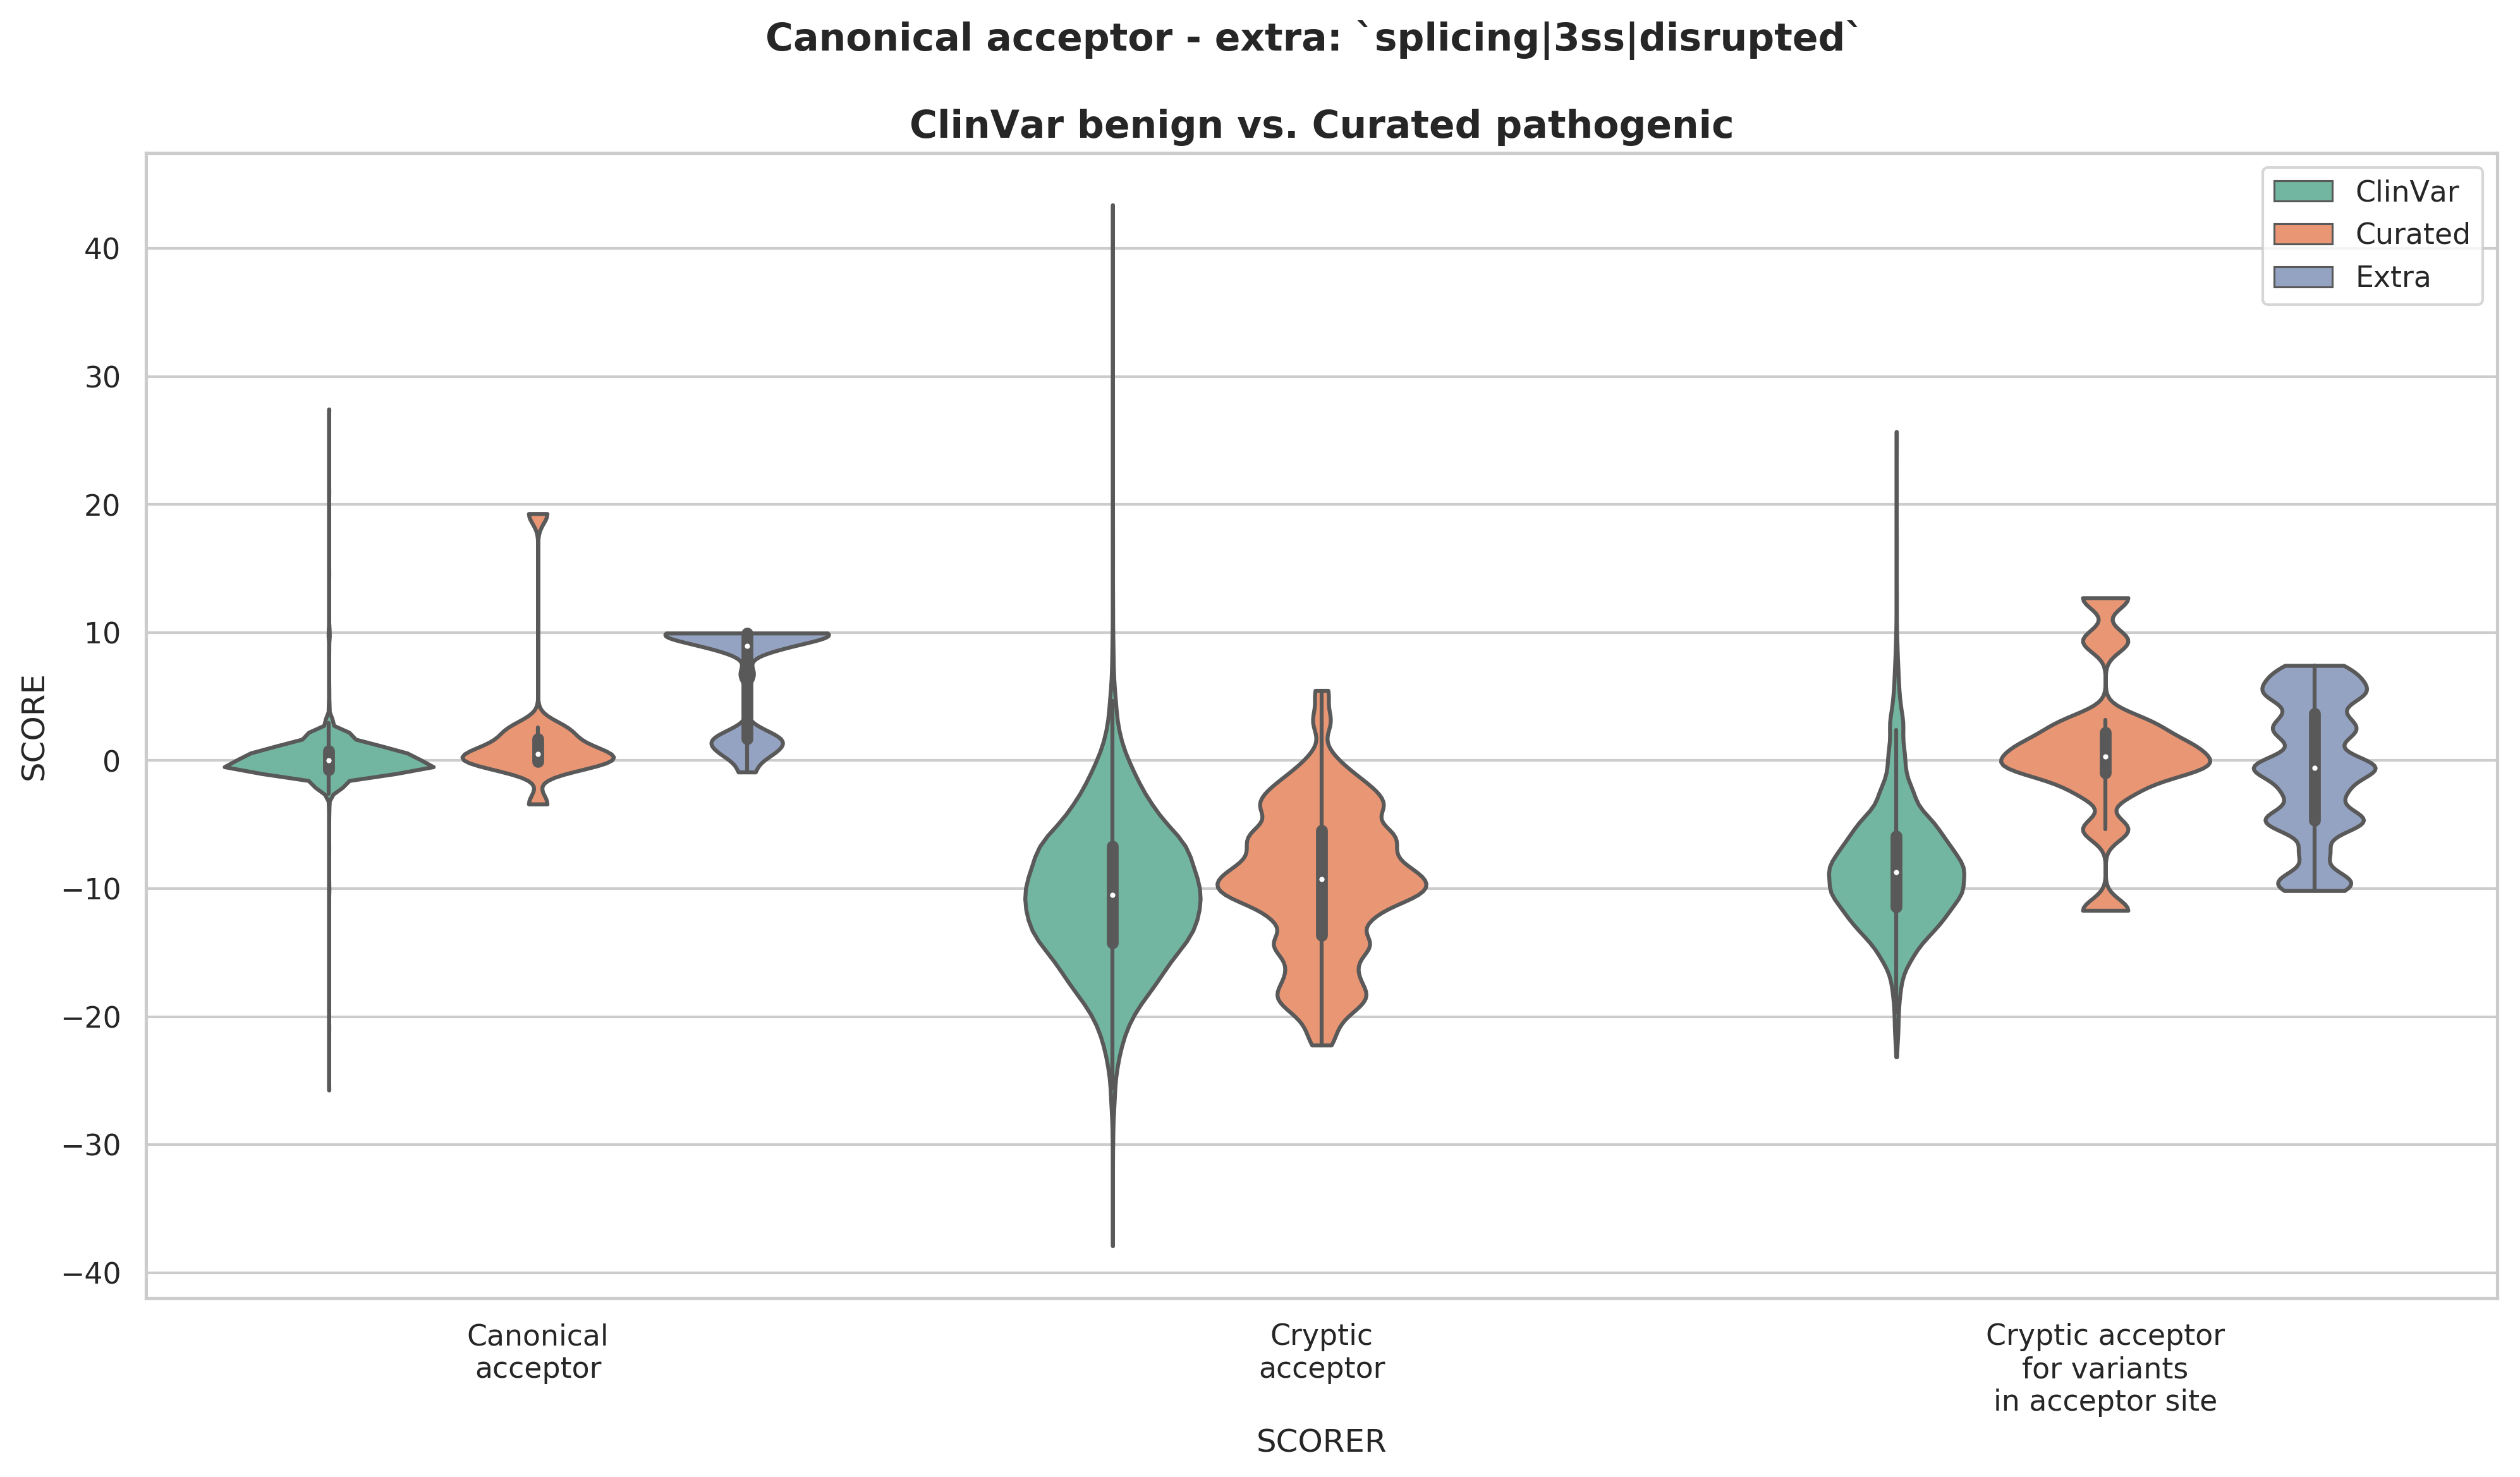

In [13]:
def canonical_acceptor_huer(row):
    p = row.PATHOMECHANISM
    if p == "splicing|3ss|disrupted":
        return "Extra"
    return row.SOURCE

fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

# prepare data
scorers = ['CANONICAL_ACCEPTOR', 'CRYPTIC_ACCEPTOR', 'CRYPTIC_ACCEPTOR_FOR_ACCEPTOR_VARIANTS']
scorer_names = ['Canonical\nacceptor',  'Cryptic\nacceptor', 'Cryptic acceptor\nfor variants\nin acceptor site']
plot_title = "Canonical acceptor - extra: `splicing|3ss|disrupted` \n\nClinVar benign vs. Curated pathogenic"

to_plot = csq_joined_melted.loc[csq_joined_melted.apply(lambda x: x.SCORER in scorers, axis=1), :]
mask = csq_joined_melted.apply(canonical_acceptor_huer, axis=1)

split_violin = sns.violinplot(x="SCORER", y="SCORE", hue=mask, data=to_plot, hue_order=hue_order, bw=.15, cut=0, ax=ax)
xticklabels = split_violin.set_xticklabels(scorer_names)
ax_title = ax.set_title(plot_title, size='x-large', weight='bold')

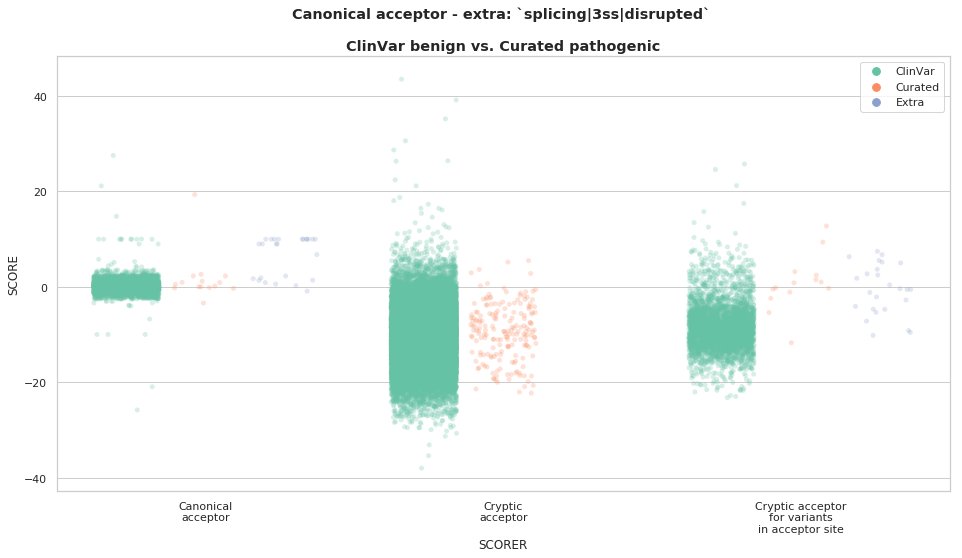

In [14]:
strip = sns.stripplot(x="SCORER", y="SCORE", hue=mask, data=to_plot, hue_order=hue_order, dodge=True, jitter=.33,
                      alpha=.25, palette="Set2")
strip.get_figure().set_size_inches(*figsize)
cat.ax.get_figure().set_dpi(dpi)
xticklabels = strip.set_xticklabels(scorer_names)
ax_title = strip.set_title(plot_title, size='x-large', weight='bold')

### Cryptic acceptor

Here, relevant variants are thos which have `splicing|3css|activated`. We want these variants to have high score when using scorers *Cryptic acceptor* and *Cryptic acceptor for variants in acceptor site*.

---------

**Actions taken below:**
- make function that assigns variants with 'pathomechanism == `splicing|3css|activated`' class *Extra*
- plot the data

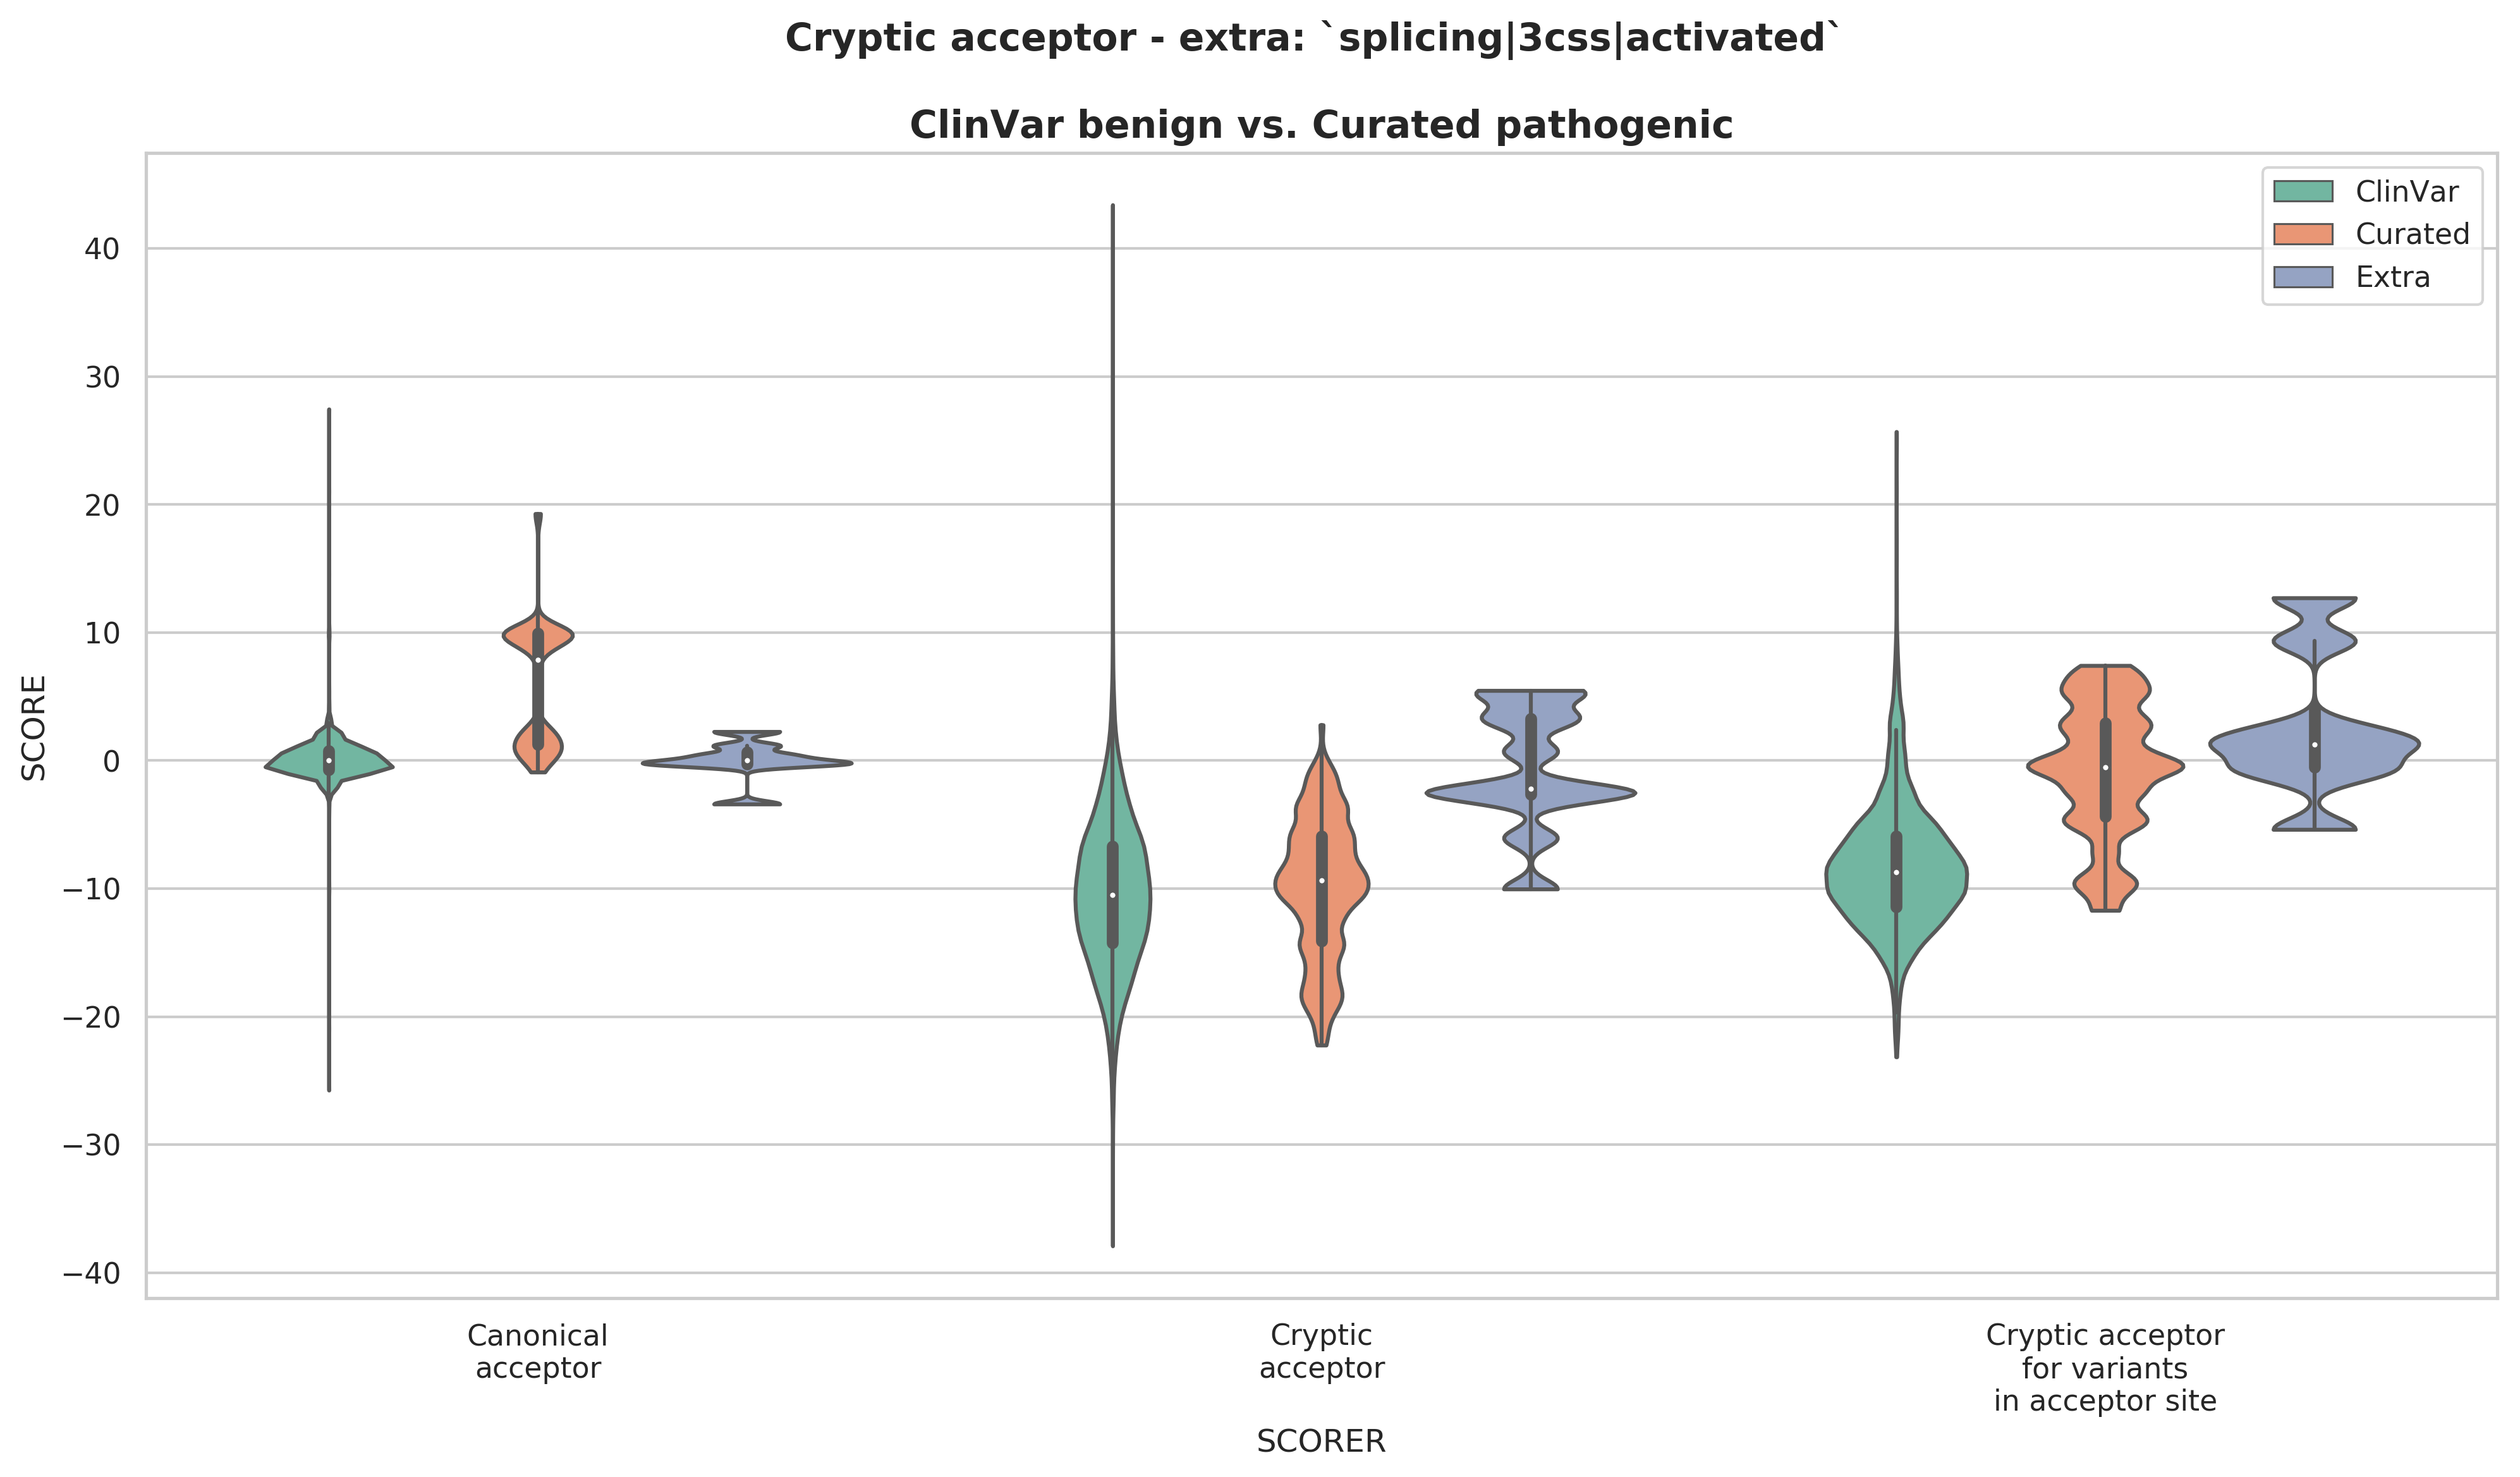

In [15]:
def cryptic_acceptor_huer(row):
    p = row.PATHOMECHANISM
    if p == "splicing|3css|activated":
        return "Extra"
    return row.SOURCE

fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

# prepare data
scorers = ['CANONICAL_ACCEPTOR', 'CRYPTIC_ACCEPTOR', 'CRYPTIC_ACCEPTOR_FOR_ACCEPTOR_VARIANTS']
scorer_names = ['Canonical\nacceptor',  'Cryptic\nacceptor', 'Cryptic acceptor\nfor variants\nin acceptor site']
plot_title = "Cryptic acceptor - extra: `splicing|3css|activated` \n\nClinVar benign vs. Curated pathogenic"

to_plot = csq_joined_melted.loc[csq_joined_melted.apply(lambda x: x.SCORER in scorers, axis=1), :]
mask = csq_joined_melted.apply(cryptic_acceptor_huer, axis=1)

split_violin = sns.violinplot(x="SCORER", y="SCORE", hue=mask, hue_order=hue_order, data=to_plot, bw=.15, cut=0, ax=ax)
xticklabels = split_violin.set_xticklabels(scorer_names)
ax_title = ax.set_title(plot_title, size='x-large', weight='bold')

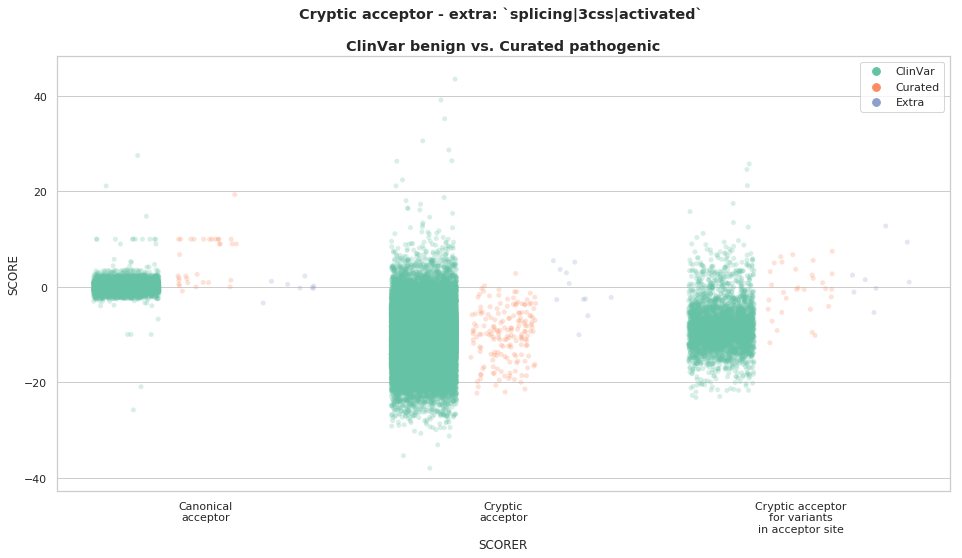

In [16]:
strip = sns.stripplot(x="SCORER", y="SCORE", hue=mask, data=to_plot, dodge=True, hue_order=hue_order, jitter=.33, alpha=.25, palette="Set2")
strip.get_figure().set_size_inches(*figsize)
cat.ax.get_figure().set_dpi(dpi)
xticklabels = strip.set_xticklabels(scorer_names)
ax_title = strip.set_title(plot_title, size='x-large', weight='bold')

## Derive scaling functions

For each scorer we want to create a function that will assign score $s > 0.95$ to top 95% of variants in the extra category.


**Problem:**

Given vector $x$ find a coefficients $s$ (*steepness*) and $t$ (*threshold*) such that 90% of $x$ values has score $y > 0.9$.

$$y = \frac{1}{1 + e^{s (x-t)}}$$

Let's solve for *threshold*:

$$t = x - \frac{ln(\frac{1}{y} - 1)}{s}$$

In [17]:
def sigmoid(x, steepness=-1, threshold=0):
    return 1 / (1 + np.exp(steepness * (x - threshold)))

def sigmoid_solved_for_threshold(x, y=0.9, steepness=-1):
    return x - np.log(1 / y - 1) / steepness

def compare_scaling(data, extra_mask, target_y_value=0.9, perc=10, steepness=-1, figsize=(14, 16)):
    """Plotting function."""
    ## PREPARE SCALER
    x_extra = np.sort(np.array(data.SCORE)[extra_mask == "Extra"])
    perc_value = np.percentile(x_extra, perc)
    threshold = sigmoid_solved_for_threshold(perc_value, y=target_y_value)
    scaler_fn = lambda x: sigmoid(x, threshold=threshold)
    
    ## PLOT
    fig, ax = plt.subplots(nrows=2, figsize=figsize, dpi=dpi)
    # plot the unscaled values
    unscaled = sns.stripplot(x=data.SCORER, y=data.SCORE, hue=extra_mask, ax=ax[0], dodge=True, alpha=.25)
    ax[0].set_title("Unscaled scores", size='x-large', weight='bold')
    
    # plot the scaled values
    scaled = sns.stripplot(x=data.SCORER, y=data.SCORE.map(scaler_fn), hue=extra_mask, ax=ax[1], dodge=True, alpha=.25)
    ax2_title = ax[1].set_title("Scores scaled such that the {}th percentil has scores > {:.2f}. \n threshold: {:.2f}, steepness: {:.2f}".format(perc, target_y_value, threshold, steepness), size='x-large', weight='bold')

### Scale cryptic donor scorer


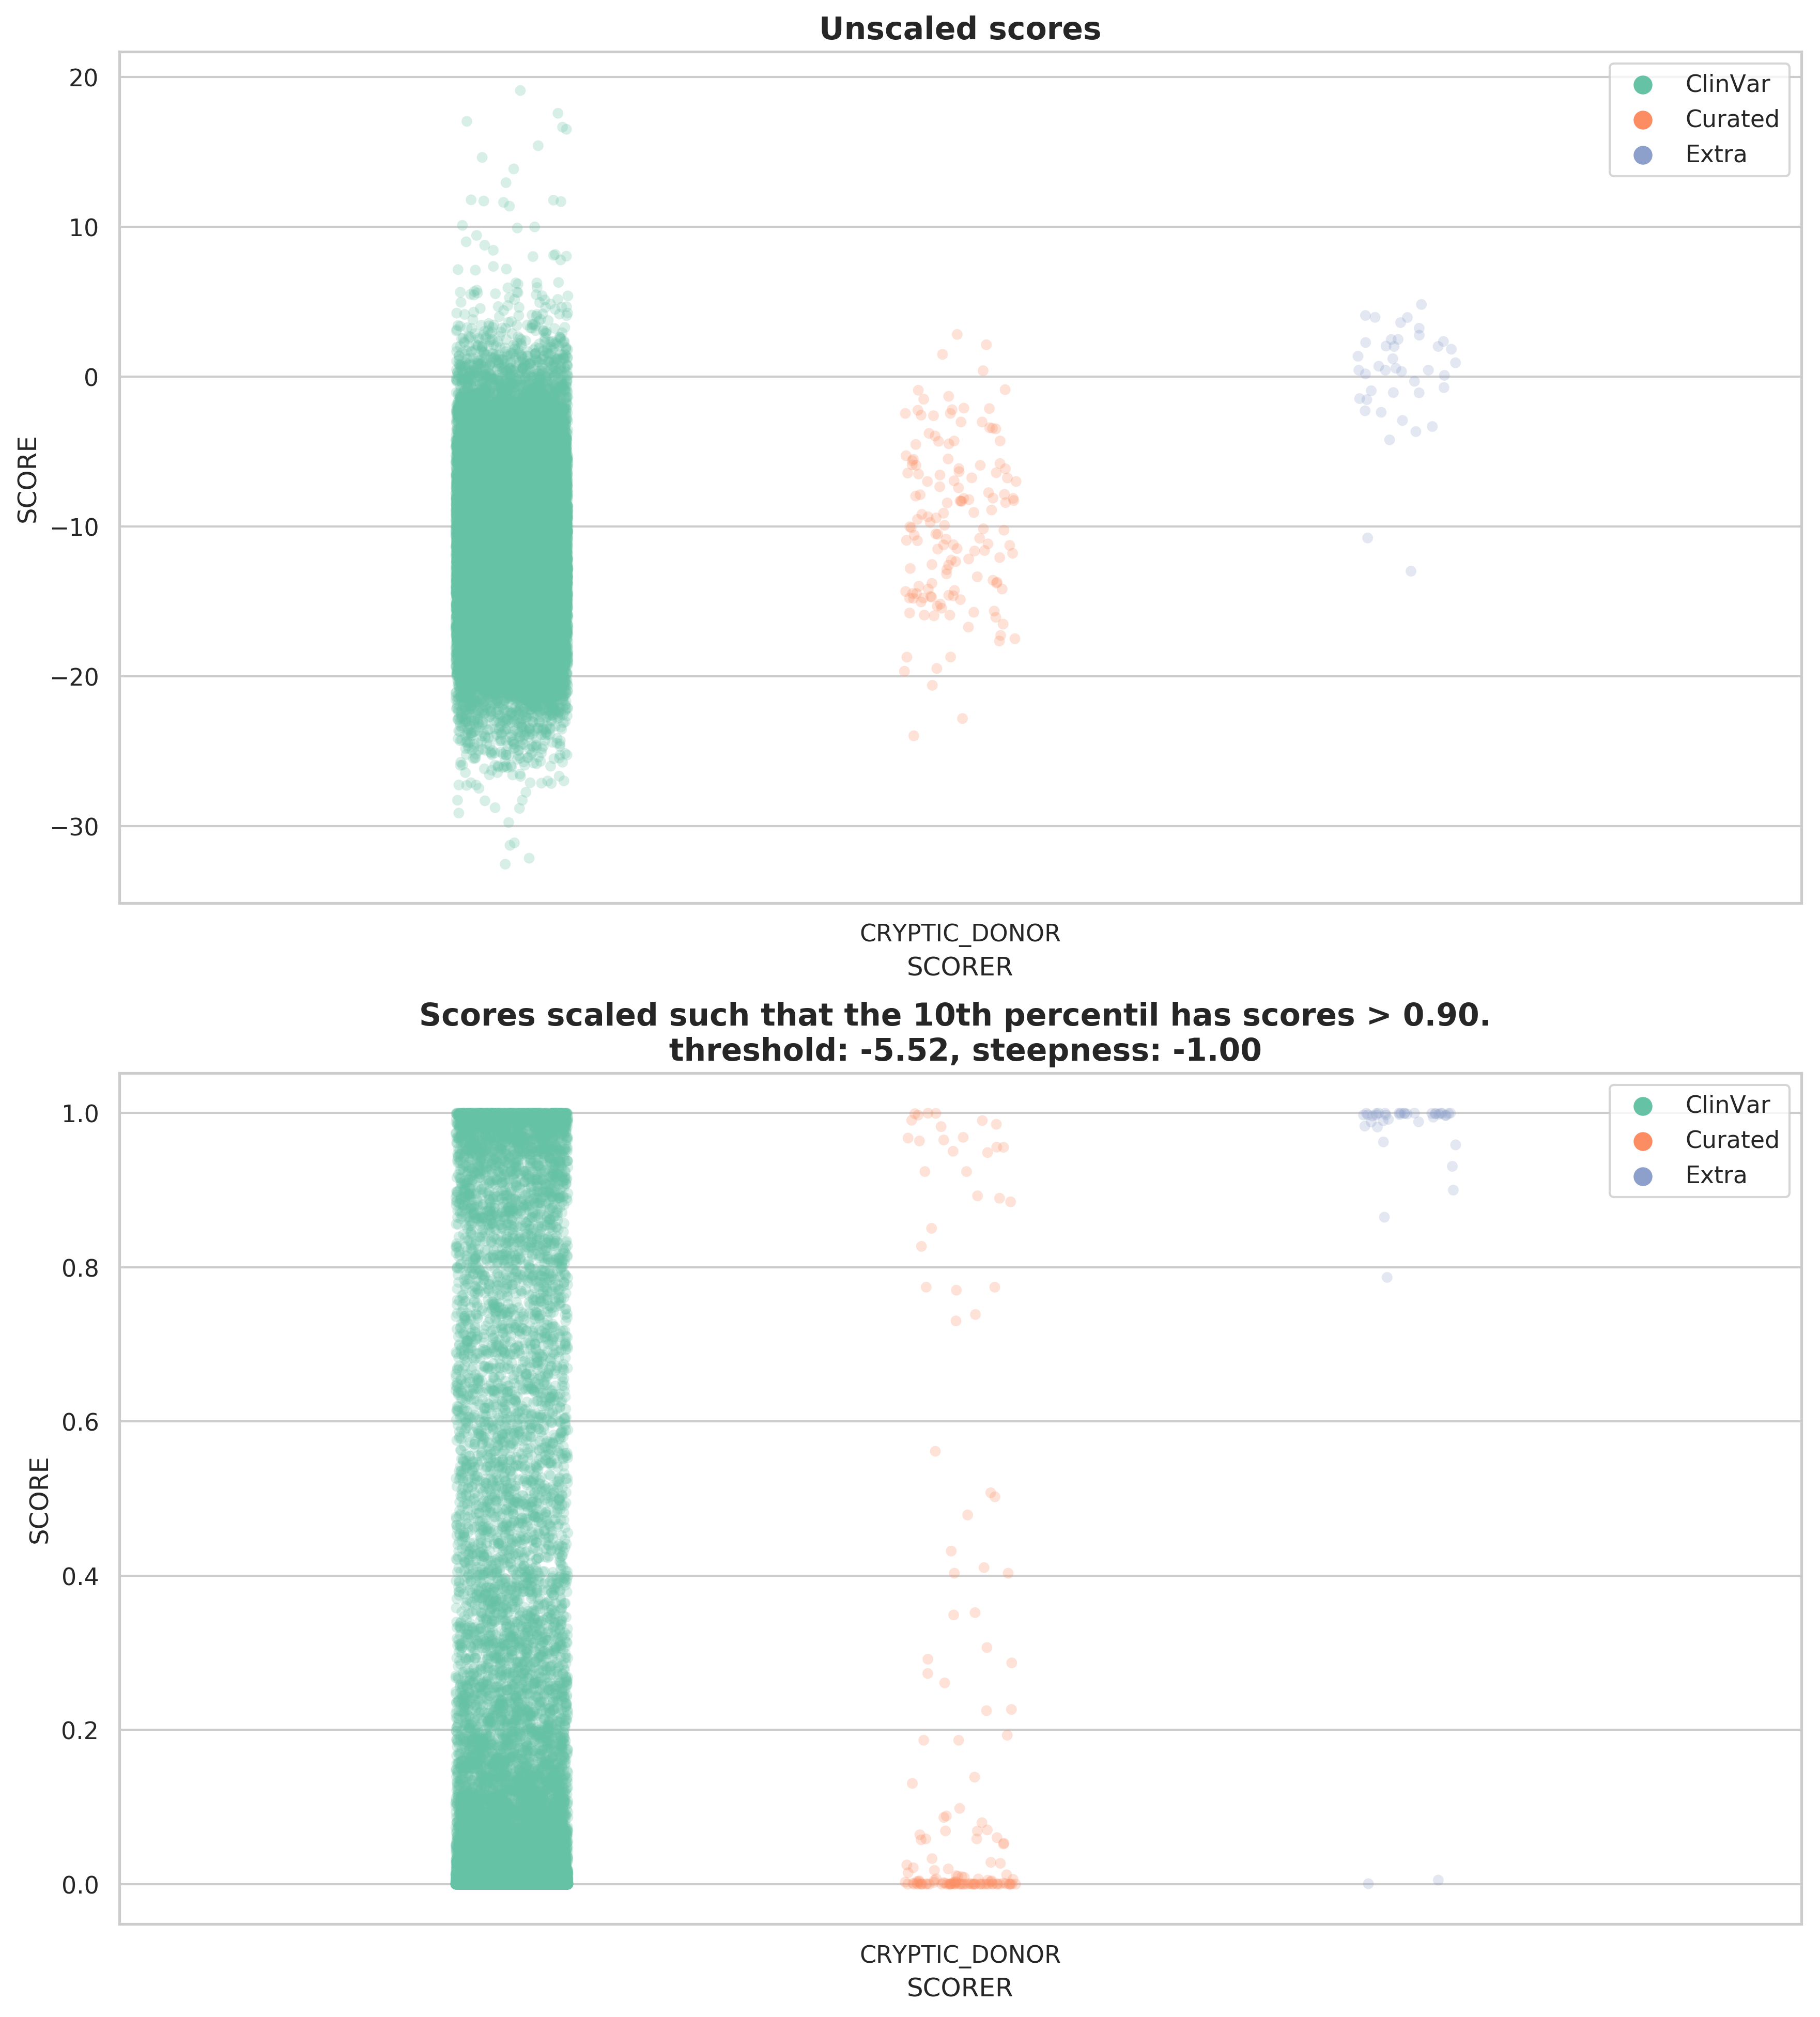

In [18]:
# get non-NaN scores for `CRYPTIC_DONOR` scorer and prepare the mask
crypt_donor = csq_joined_melted.loc[(csq_joined_melted.SCORER == "CRYPTIC_DONOR") & (~csq_joined_melted.SCORE.isna()), :]

crypt_donor_mask = crypt_donor.apply(cryptic_donor_huer, axis=1)

compare_scaling(crypt_donor, crypt_donor_mask)